# Task 1: EDA and Preprocessing
Loads, filters, cleans, and analyzes the 5.2 GB CFPB complaints dataset.

## Inspect dataset

In [ ]:
# Cell 1: Inspect dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

file_path = '../data/raw/complaints.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at: {os.path.abspath(file_path)}")

df_sample = pd.read_csv(file_path, nrows=1000)
print("Columns:", df_sample.columns.tolist())
print("Unique products:", df_sample['Product'].unique().tolist())
print("Sample issues:", df_sample['Issue'].unique().tolist())
if 'Sub-product' in df_sample.columns:
    print("Sample sub-products:", df_sample['Sub-product'].unique().tolist())


Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']
Unique products: ['Credit reporting or other personal consumer reports', 'Debt collection', 'Credit card', 'Checking or savings account', 'Money transfer, virtual currency, or money service']
Sample issues: ['Incorrect information on your report', 'Attempts to collect debt not owed', 'Improper use of your report', 'Written notification about debt', "Problem with a company's investigation into an existing problem", 'Problem with fraud alerts or security freezes', 'Communication tactics', 'False statements or representation', 'Managing an account', 'Closing an account', 'Credit monitoring or identity theft protection services', 'Unable to get your credit repo

## Filter dataset

In [9]:
products = [
    'Credit card or prepaid card',
    'Consumer Loan',
    'Checking or savings account',
    'Money transfer, virtual currency, or money service'
]

output_file = '../data/processed/filtered_complaints.csv'
os.makedirs('../data/processed', exist_ok=True)
if os.path.exists(output_file):
    os.remove(output_file)

chunk_size = 10000
first_chunk = True
for chunk in pd.read_csv('../data/raw/complaints.csv', chunksize=chunk_size, low_memory=False):
    chunk_filtered = chunk[
        (chunk['Product'].isin(products)) & 
        (chunk['Consumer complaint narrative'].notnull())
    ]
    if not chunk_filtered.empty:
        mode = 'w' if first_chunk else 'a'
        header = first_chunk
        chunk_filtered.to_csv(output_file, mode=mode, header=header, index=False)
        first_chunk = False
    print(f"Processed chunk, filtered size: {len(chunk_filtered)}")

Processed chunk, filtered size: 0
Processed chunk, filtered size: 4
Processed chunk, filtered size: 13
Processed chunk, filtered size: 17
Processed chunk, filtered size: 17
Processed chunk, filtered size: 8
Processed chunk, filtered size: 85
Processed chunk, filtered size: 25
Processed chunk, filtered size: 13
Processed chunk, filtered size: 23
Processed chunk, filtered size: 8
Processed chunk, filtered size: 26
Processed chunk, filtered size: 23
Processed chunk, filtered size: 66
Processed chunk, filtered size: 55
Processed chunk, filtered size: 48
Processed chunk, filtered size: 20
Processed chunk, filtered size: 7
Processed chunk, filtered size: 14
Processed chunk, filtered size: 20
Processed chunk, filtered size: 17
Processed chunk, filtered size: 24
Processed chunk, filtered size: 20
Processed chunk, filtered size: 25
Processed chunk, filtered size: 15
Processed chunk, filtered size: 35
Processed chunk, filtered size: 28
Processed chunk, filtered size: 16
Processed chunk, filtered

## Handle BNPL

In [10]:
df_filtered = pd.read_csv('../data/processed/filtered_complaints.csv')
bnpl_complaints = df_filtered[df_filtered['Issue'].str.contains('BNPL|installment|pay later', case=False, na=False)]
print(f"BNPL-related complaints: {len(bnpl_complaints)}")
if len(bnpl_complaints) > 0:
    print("Sample BNPL issues:", bnpl_complaints['Issue'].head().tolist())

df_filtered['Product'] = df_filtered.apply(
    lambda row: 'Buy Now, Pay Later (BNPL)' if pd.notnull(row['Issue']) and any(term in row['Issue'].lower() for term in ['bnpl', 'installment', 'pay later']) else row['Product'],
    axis=1
)
df_filtered.to_csv('../data/processed/filtered_complaints.csv', index=False)
print(f"Updated dataset size: {len(df_filtered)} rows")
print("Unique products:", df_filtered['Product'].unique())

BNPL-related complaints: 0
Updated dataset size: 355635 rows
Unique products: ['Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Credit card or prepaid card' 'Consumer Loan']


## Clean narratives

In [11]:
def clean_narrative(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    boilerplate = ['i am writing to file a complaint', 'please help']
    for phrase in boilerplate:
        text = text.replace(phrase, '')
    return text.strip()

df_filtered = pd.read_csv('../data/processed/filtered_complaints.csv')
df_filtered['Consumer complaint narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'] != '']
df_filtered.to_csv('../data/processed/filtered_complaints.csv', index=False)
print(f"Cleaned dataset size: {len(df_filtered)} rows")

Cleaned dataset size: 355635 rows


## Complaint distribution

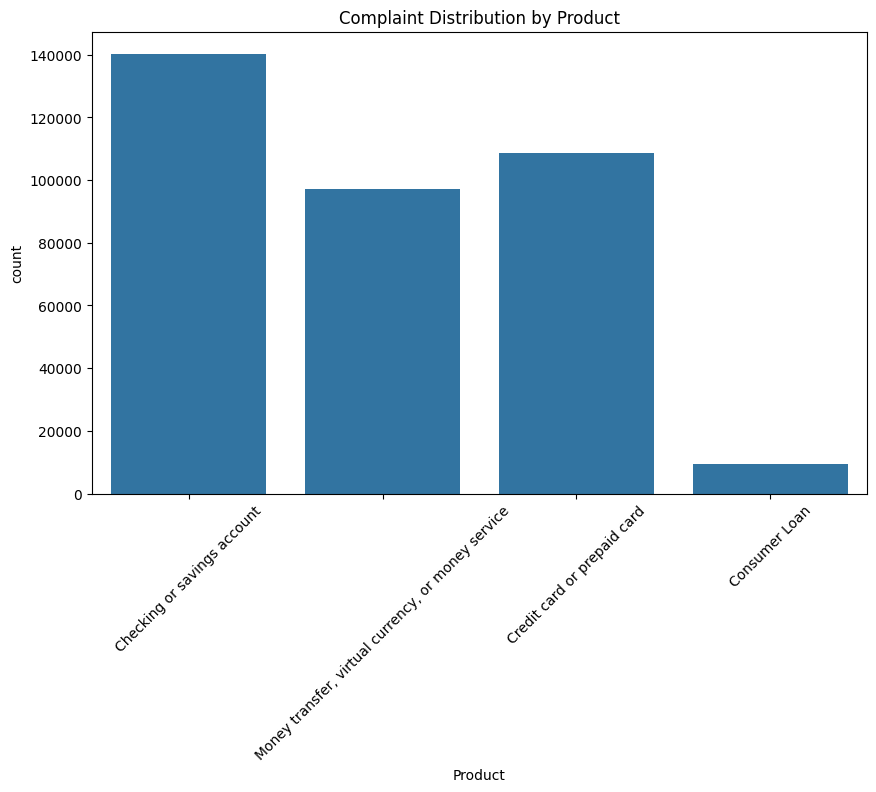

In [12]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='Product')
plt.title('Complaint Distribution by Product')
plt.xticks(rotation=45)
os.makedirs('../reports', exist_ok=True)
plt.savefig('../reports/product_distribution.png')
plt.show()

## Narrative length

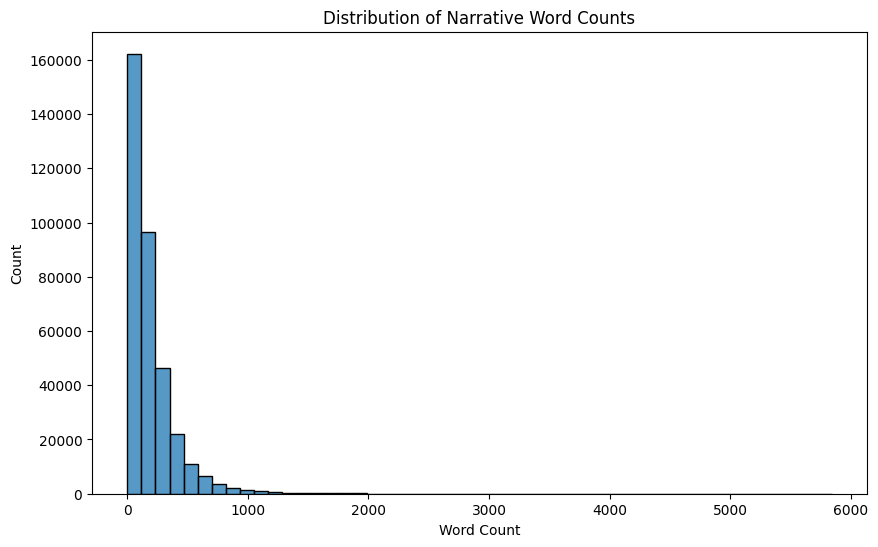

Narrative length stats:
count    355635.000000
mean        202.027070
std         222.998991
min           1.000000
25%          85.000000
50%         132.000000
75%         249.000000
max        5842.000000
Name: narrative_length, dtype: float64


In [13]:
df_filtered['narrative_length'] = df_filtered['Consumer complaint narrative'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['narrative_length'], bins=50)
plt.title('Distribution of Narrative Word Counts')
plt.xlabel('Word Count')
plt.savefig('../reports/narrative_length.png')
plt.show()
print("Narrative length stats:")
print(df_filtered['narrative_length'].describe())

## Narrative presence

In [14]:
df_sample = pd.read_csv('../data/raw/complaints.csv', nrows=10000)
print(f"Complaints with narratives: {len(df_sample[df_sample['Consumer complaint narrative'].notnull()])}")
print(f"Complaints without narratives: {len(df_sample[df_sample['Consumer complaint narrative'].isnull()])}")

Complaints with narratives: 2
Complaints without narratives: 9998
